In [4]:
def f(x):
    return 3*x**2 -4*x +5

In [5]:
f(3.0)

20.0

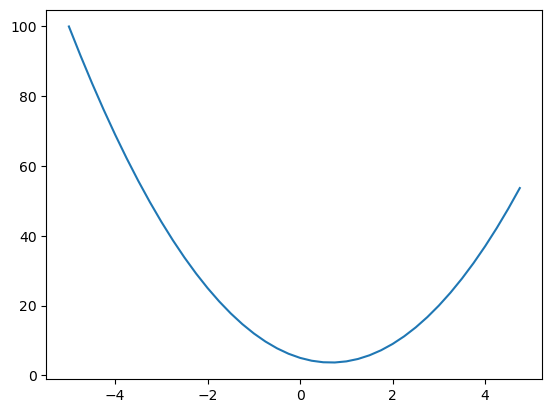

In [6]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [7]:
h = 0.00000001
x = 2/3
(f(x + h)-f(x))/h

0.0

In [8]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

a += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', {(d2-d1)/h} )

d1 4.0
d2 3.999699999999999
slope {-3.000000000010772}


In [9]:
class Value:
    
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
  
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [10]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        nodes.add(v)
        for child in v._prev:
            edges.add((child, v))
            build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name= uid, label= "{%s | data %.4f| grad %.4f }" % (n.label, n.data, n.grad), shape = "record")
        if n._op:
            dot.node(name= uid + n._op, label= n._op)
            dot.edge(uid+ n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [11]:
#inputs x1 x2
x1 = Value (2.0, label='x1')
x2 = Value(0.0, label='x2') 
#weights of the neuron w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value (1.0, label='w2')
#bias of the neuron
b= Value (6.881377, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1' 
x2w2= x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

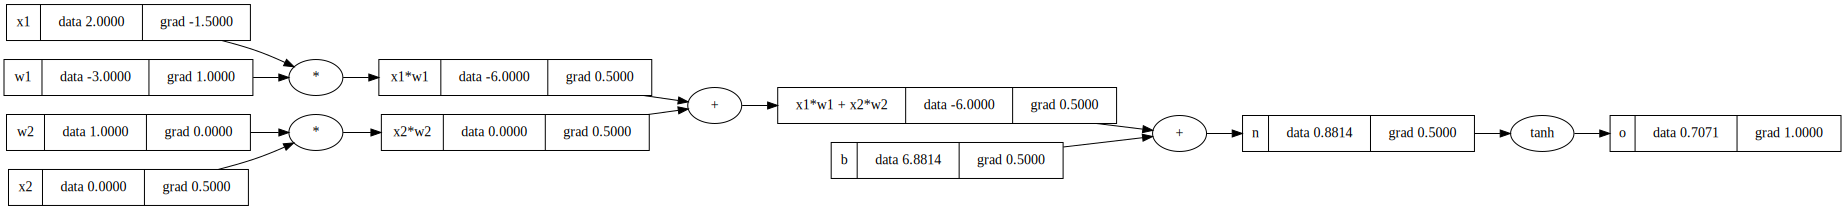

In [12]:
draw_dot(o)

Value(data=0.8813769999999996)


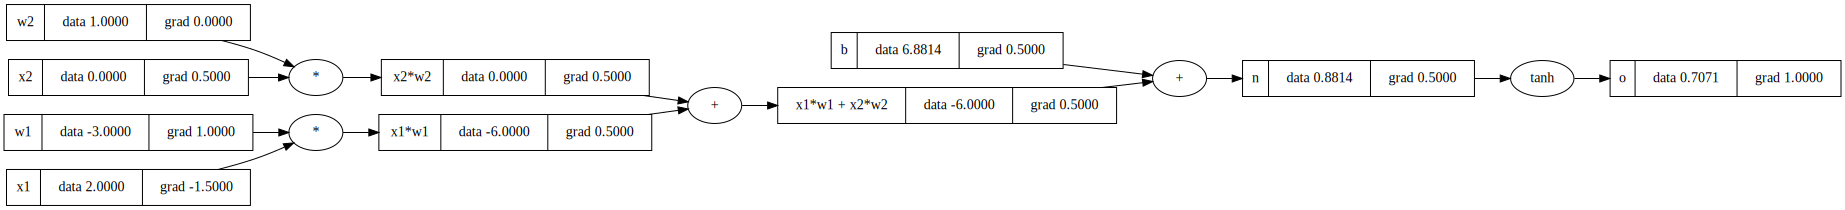

In [13]:
x1 = Value (2.0, label='x1')
x2 = Value(0.0, label='x2') 
#weights of the neuron w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value (1.0, label='w2')
#bias of the neuron
b= Value (6.881377, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1' 
x2w2= x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
print(n)
o = n.tanh()
#------------
o.label = 'o'
o.backward()
draw_dot(o)

In [14]:
a = Value(3.5)
b = Value(6)
a - 3

Value(data=0.5)

In [15]:
# inputs x1,x2
x1 = Value (2.0, label='x1') 
x2 = Value(0.0, label='x2')
#weights w1,w2
w1 = Value (-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron 
b = Value(6.8813735870195432, label='b')

# x1*wl + x2*w2 + b 
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2' 
n = x1w1x2w2+ b; n. label = 'n'
#-----
o= n.tanh(e build_topo() function inside the backward() method does not handle cycles in the computation graph, which can cause)
#-----------
o.label = '0'
o.backward()
draw_dot(o)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (633685025.py, line 16)

In [16]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]
    
    
    
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    


In [17]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.8162741282503239)

In [18]:
xs = [
    [2.0, 3.0, -1],
    [3.0, -1.0 , 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [19]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
loss


Value(data=2.46479892955083)

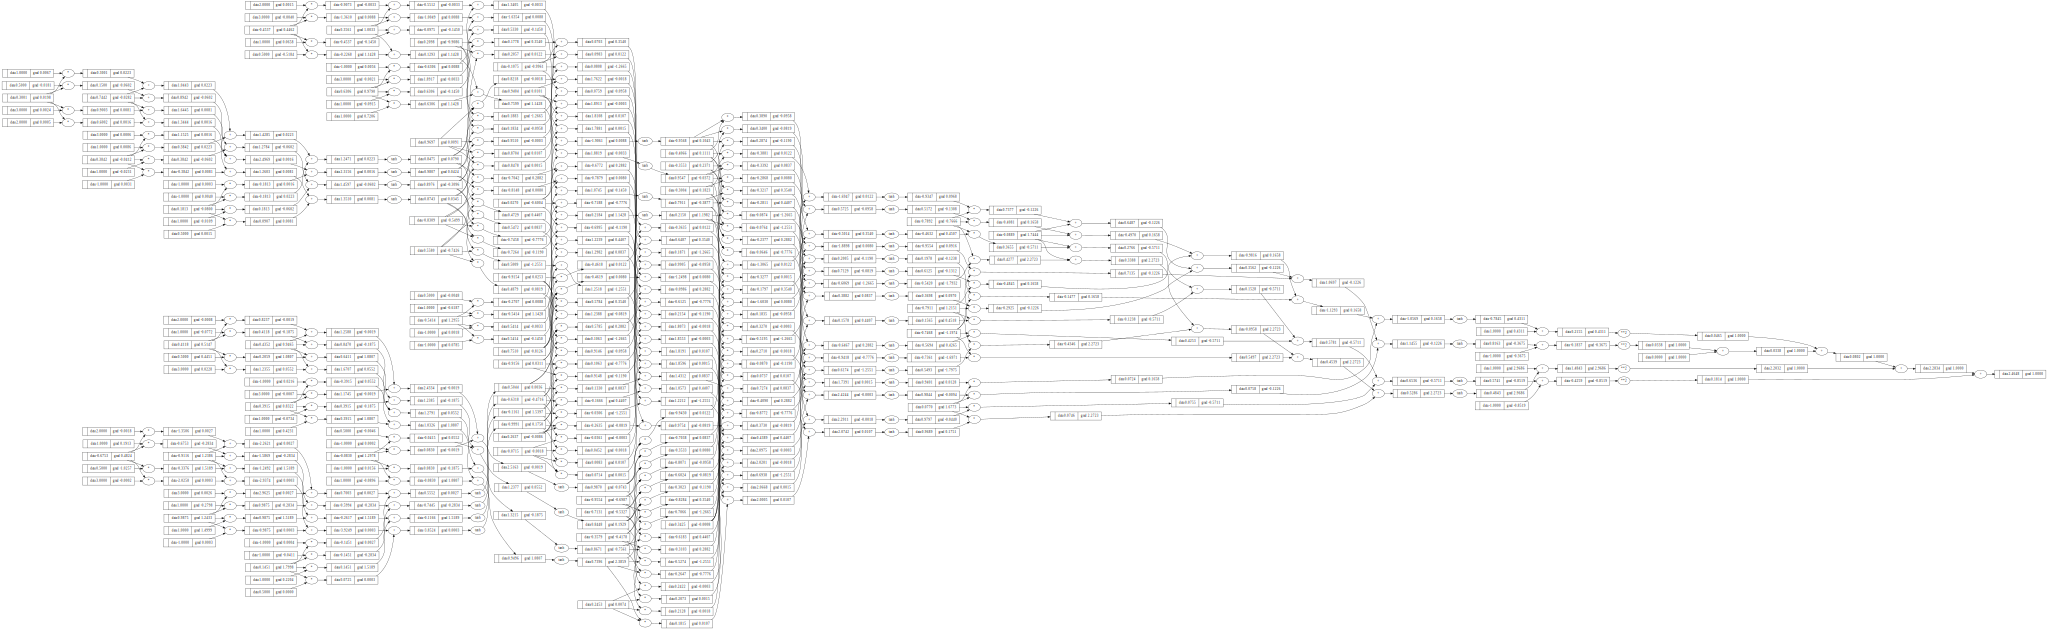

In [20]:
loss.backward()
draw_dot(loss)

In [53]:
n.layers[0].neurons[0].w[0].data

0.49606125609643703

In [76]:
for p in n.parameters():
    p.data += -0.01 *p.grad
